In [1]:
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.utils import Sequence

# Define the directories
train_eval_dir = '/local_dir/Train_Images'
test_dir = '/local_dir/Test_Images'

# Function to load and resize images
def load_and_resize_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [64, 2048])
    return image

# Function to load datasets
def load_dataset(image_dir):
    file_paths = []
    for root, _, files in os.walk(image_dir):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png'):
                file_paths.append(os.path.join(root, file))
    return file_paths

# Load datasets
train_file_paths = load_dataset(train_eval_dir)
test_file_paths = load_dataset(test_dir)

2024-07-18 09:16:24.265092: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-18 09:16:24.279684: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-18 09:16:24.284038: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-18 09:16:24.295946: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Custom data generator to yield random noise and corresponding images
class DataGenerator(Sequence):
    def __init__(self, file_paths, batch_size, input_shape):
        self.file_paths = file_paths
        self.batch_size = batch_size
        self.input_shape = input_shape

    def __len__(self):
        return len(self.file_paths) // self.batch_size

    def __getitem__(self, idx):
        batch_file_paths = self.file_paths[idx * self.batch_size: (idx + 1) * self.batch_size]
        images = [load_and_resize_image(fp) for fp in batch_file_paths]
        images = tf.stack(images)
        noise = tf.random.normal(shape=(self.batch_size,) + self.input_shape)
        return noise, images

# Define input shape for noise
input_shape = (64, 2048, 1)

In [14]:
# Function to create a complex UNet model
def create_complex_unet(input_shape):
    # Encoder
    def encoder_block(input_tensor, num_filters):
        x = Conv2D(num_filters, (3, 3), padding="same", activation="relu")(input_tensor)
        x = Conv2D(num_filters, (3, 3), padding="same", activation="relu")(x)
        p = tf.keras.layers.MaxPooling2D((2, 2))(x)
        return x, p

    # Decoder
    def decoder_block(input_tensor, skip_features, num_filters):
        x = Conv2DTranspose(num_filters, (3, 3), strides=2, padding="same", activation="relu")(input_tensor)
        x = concatenate([x, skip_features])
        x = Conv2D(num_filters, (3, 3), padding="same", activation="relu")(x)
        x = Conv2D(num_filters, (3, 3), padding="same", activation="relu")(x)
        return x

    inputs = Input(shape=input_shape)
    
    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    s5, p5 = encoder_block(p4, 1024)
    
    # Bottleneck
    b1 = Conv2D(2048, (3, 3), padding="same", activation="relu")(p5)
    b1 = Conv2D(2048, (3, 3), padding="same", activation="relu")(b1)
    
    # Decoder
    d1 = decoder_block(b1, s5, 1024)
    d2 = decoder_block(d1, s4, 512)
    d3 = decoder_block(d2, s3, 256)
    d4 = decoder_block(d3, s2, 128)
    d5 = decoder_block(d4, s1, 64)
    
    outputs = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d5)
    
    return Model(inputs, outputs)

# Create complex UNet model
complex_unet_model = create_complex_unet(input_shape)

# Compile the model
complex_unet_model.compile(optimizer=Adam(learning_rate=1e-5), loss=MeanSquaredError())
complex_unet_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 64, 2048,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_69 (Conv2D)  │ (None, 64, 2048,  │        640 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_70 (Conv2D)  │ (None, 64, 2048,  │     36,928 │ conv2d_69[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 32, 1024,  │          0 │ conv2d_70[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_71 (Conv2D)  │ (None, 32, 1024,  │     73,856 │ max_pooling2d_15… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_72 (Conv2D)  │ (None, 32, 1024,  │    147,584 │ conv2d_71[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 16, 512,   │          0 │ conv2d_72[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_73 (Conv2D)  │ (None, 16, 512,   │    295,168 │ max_pooling2d_16… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_74 (Conv2D)  │ (None, 16, 512,   │    590,080 │ conv2d_73[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 8, 256,    │          0 │ conv2d_74[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_75 (Conv2D)  │ (None, 8, 256,    │  1,180,160 │ max_pooling2d_17… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_76 (Conv2D)  │ (None, 8, 256,    │  2,359,808 │ conv2d_75[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 4, 128,    │          0 │ conv2d_76[0][0]   │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_77 (Conv2D)  │ (None, 4, 128,    │  4,719,616 │ max_pooling2d_18… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_78 (Conv2D)  │ (None, 4, 128,    │  9,438,208 │ conv2d_77[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 2, 64,     │          0 │ conv2d_78[0][0]   │
│ (MaxPooling2D)      │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_79 (Conv2D)  │ (None, 2, 64,     │ 18,876,416 │ max_pooling2d_19

 Total params: 138,328,385 (527.68 MB)

 Trainable params: 138,328,385 (527.68 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Create data generators for training and testing
batch_size = 1
train_gen = DataGenerator(train_file_paths, batch_size, input_shape)
test_gen = DataGenerator(test_file_paths, batch_size, input_shape)

# Train the model
complex_unet_model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=50
)

Epoch 1/50
 10865/149664 ━━━━━━━━━━━━━━━━━━━━ 1:20:46 35ms/step - loss: 0.0961

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


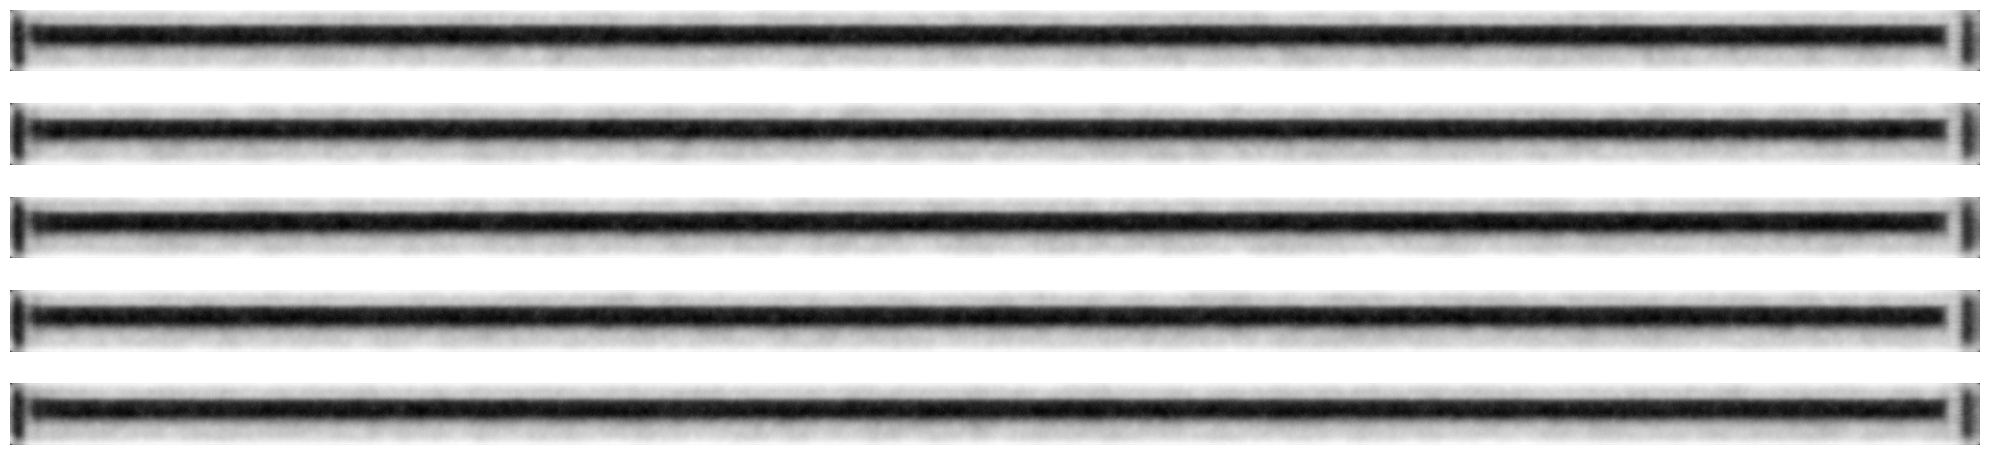

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Function to generate images from random noise
def generate_images(model, num_images, input_shape):
    # Generate random noise
    noise = tf.random.normal(shape=(num_images,) + input_shape)
    # Predict images from random noise using the trained model
    generated_images = model.predict(noise)
    return generated_images

# Number of images to generate
num_images = 5  # Change this to generate more images

# Generate images from random noise
generated_images = generate_images(complex_unet_model, num_images, input_shape)

# Function to plot generated images in a single column
def plot_generated_images(images, num_images):
    fig, axes = plt.subplots(num_images, 1, figsize=(20, 5))
    for i in range(num_images):
        axes[i].imshow(images[i, :, :, 0], cmap='gray')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Plot the generated images in a single column
plot_generated_images(generated_images, num_images)